In [1]:
import gensim
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid
from nltk.corpus import wordnet as wn
import gensim.downloader

## Gold Standard Data Loading

In [2]:
sl = pd.read_csv('wordsim_relatedness_goldstandard.txt', sep='\t')
sl.columns = ['word_1', 'word_2', 'score']
sl = sl[:100]
ls = pd.DataFrame(data=sl, columns=['word_1', 'word_2'])
ls = ls[['word_2', 'word_1']]
ls = ls.rename(columns={"word_1": "word_2", "word_2": "word_1"})

In [3]:
sl = pd.concat([sl,ls], axis=0).reset_index(drop=True).drop([3, 9, 10, 12, 17, 99, 43, 103, 109, 110, 112, 117, 143, 168, 199, 68, 
                                              161, 61]).reset_index(drop=True)

## Human data loading and processing

In [4]:
df = pd.read_csv('data_tutorial_2021-01-18.csv',encoding='utf16', sep='\t')
df = df.drop(columns=['CASE', 'SERIAL', 'REF', 'QUESTNNR', 'MODE', 'STARTED', 'MAILSENT'])
df.columns = df.iloc[0]
df = df.dropna().reset_index(drop=True).drop([4, 0]).reset_index(drop=True)
df = df.iloc[:, :200]
df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce', axis=1)
df.iloc[:, 2:] = df.iloc[:, 2:] - 1
df.iloc[7, 1] = 22
df.iloc[9, 0] = 'Russian'
df.iloc[10, 0] = 'Russian'
df.iloc[14, 0] = 'Russian'
# df.loc[17] = df.iloc[:, 2:101].mean()
# df.loc[18] = df.iloc[:, 101:].mean()
# df.iloc[17, 101:] = df.iloc[17, 2:101].values
# df.iloc[18, 2:101] = df.iloc[18, 101:].values
# df.loc[19] = df.loc[17] - df.loc[18] # W1W2 - W2W1
a = [3, 9, 10, 12, 17, 43, 103, 109, 110, 112, 117, 143, 168, 68, 161, 61]
df.drop(df.columns[[b + 2 for b in a]], axis = 1, inplace=True)
df

,Native language: [01],Age: [01],Pairs 1: Jerusalem\tIsrael,Pairs 1: planet\tgalaxy,Pairs 1: canyon\tlandscape,Pairs 1: day\tsummer,Pairs 1: day\tdawn,Pairs 1: country\tcitizen,Pairs 1: planet\tpeople,Pairs 1: environment\tecology,...,Pairs 2: emergency\tvictim,Pairs 2: car\tluxury,Pairs 2: implement\ttool,Pairs 2: price\tcompetition,Pairs 2: doctor\tpsychology,Pairs 2: equality\tgender,Pairs 2: category\tlisting,Pairs 2: archive\tvideo,Pairs 2: stock\toil,Pairs 2: office\tgovernor
0,Korean,28,9,9,9,6,2,9,5,8,...,7,9,9,9,7,6,9,8,8,9
1,Chinese,24,9,8,5,3,2,6,5,9,...,5,5,2,3,6,6,7,6,3,7
2,Arabic,30,0,6,4,1,6,8,8,7,...,7,7,6,7,5,8,3,3,6,6
3,Russian,28,4,2,3,4,3,3,0,4,...,0,2,2,3,3,2,3,1,1,1
4,Russian,23,8,6,8,5,1,8,6,9,...,2,6,6,8,5,8,7,8,2,5
5,Russian,23,5,4,5,6,10,10,4,5,...,7,4,0,3,5,5,10,5,4,5
6,Russian,19,8,10,10,8,8,10,8,9,...,10,10,5,10,10,8,5,10,6,8
7,Indonesian,22,5,10,10,5,4,10,2,10,...,0,5,10,0,10,10,5,0,0,5
8,Russian,15,10,9,7,4,1,8,7,10,...,0,7,3,8,9,9,5,7,1,5
9,Russian,50,9,9,9,7,9,2,8,8,...,3,9,2,2,10,5,7,8,8,7


#### Distribution of human answers for each pair of words

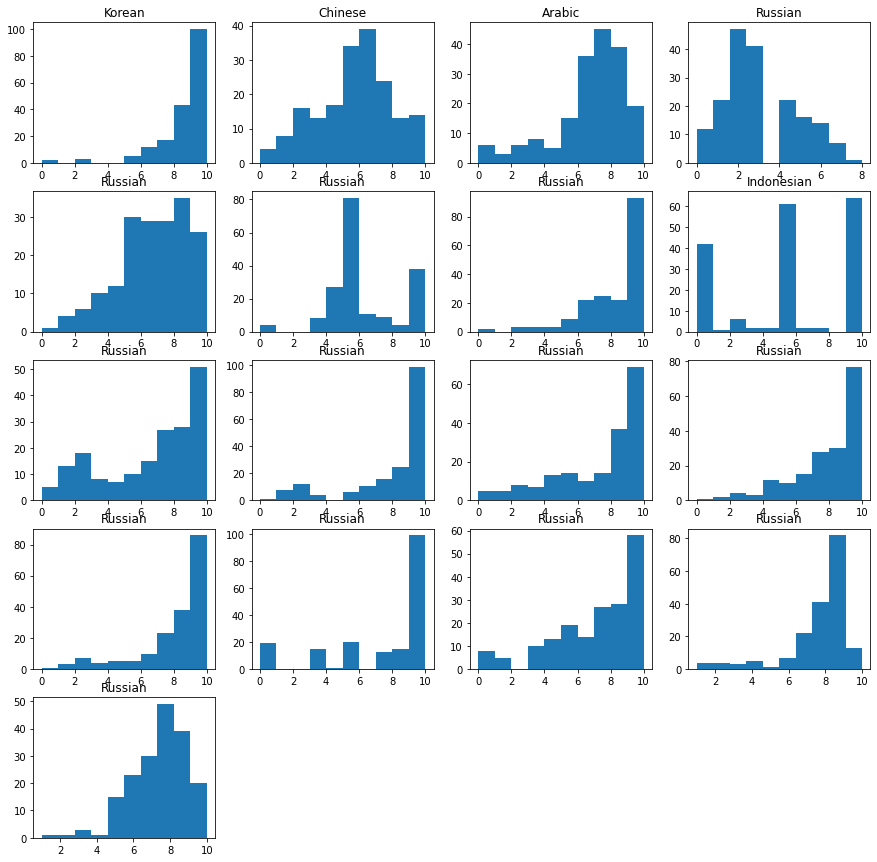

In [5]:
plt.figure(figsize=(15,15))
for i in range(1, 18):
    plt.subplot(5, 4, i)
    plt.hist(df.iloc[i-1, 2:])
    plt.title(df.iloc[i-1, 0])

In [6]:
df_full = pd.DataFrame(sl[0:91].drop(columns=['score']).reset_index(drop=True))
df_full['gs'] = sl['score'][0:91]
df_full['normal_average'] = df.iloc[:, 2:93].mean().reset_index(drop=True)
df_full['reversed_average'] = df.iloc[:, 93:].mean().reset_index(drop=True)
df_full['na-gs'] = df_full['normal_average'] - df_full['gs']
df_full

,word_1,word_2,gs,normal_average,reversed_average,na-gs
0,Jerusalem,Israel,8.46,7.647059,7.647059,-0.812941
1,planet,galaxy,8.11,8.058824,8.176471,-0.051176
2,canyon,landscape,7.53,7.764706,7.764706,0.234706
3,day,summer,3.94,4.882353,5.647059,0.942353
4,day,dawn,7.53,5.235294,4.882353,-2.294706
...,...,...,...,...,...,...
86,gender,equality,6.41,6.647059,6.647059,0.237059
87,listing,category,6.38,5.294118,6.294118,-1.085882
88,video,archive,6.34,5.294118,5.529412,-1.045882
89,oil,stock,6.34,4.058824,4.941176,-2.281176


#### Plotting the Human Data and the Gold Standard Data

Text(0.5, 1.0, 'The smoothed points lines')

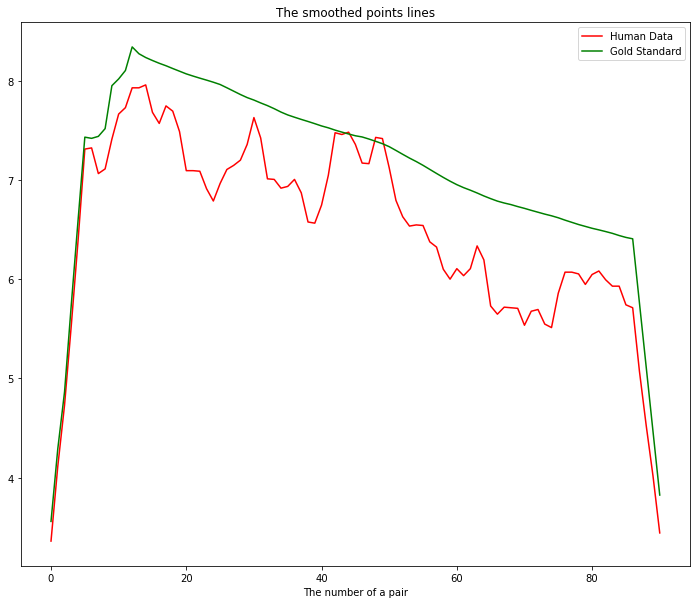

In [7]:
x = [x for x in range(91)]
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
plt.figure(figsize=(12,10))
plt.plot(x, smooth(df_full['normal_average'], 10), color='red')
plt.plot(x, smooth(df_full['gs'], 10), color='green')
plt.xlabel('The number of a pair')
plt.legend(['Human Data', 'Gold Standard'])
plt.title('The smoothed points lines')
#plt.plot(x, df_out.iloc[21, 2:93], color='blue')

#### Computing correlation and t-test

In [8]:
df_full.corr()

,gs,normal_average,reversed_average,na-gs
gs,1.000000,0.536647,0.463586,-0.038245
normal_average,0.536647,1.000000,0.924622,0.822666
reversed_average,0.463586,0.924622,1.000000,0.782625
na-gs,-0.038245,0.822666,0.782625,1.000000


In [9]:
stats.ttest_ind(df_full['normal_average'], df_full['gs'])

Ttest_indResult(statistic=-3.8451521883740085, pvalue=0.0001669997048643289)

#### Creating a dataset with normal, reversed_pairs, and human average score

In [10]:
#data = pd.DataFrame(sl.drop(columns=['score']))
#data['human_average'] = pd.concat([df_full['normal_average'], df_full['reversed_average']], axis=1, ignore_index=True)
data= pd.DataFrame(data = 
                   pd.concat([df_full['normal_average'], df_full['reversed_average']], axis=0, ignore_index=True),
                  columns=
                  ['human_average'])
data['word_1'] = sl['word_1']
data['word_2'] = sl['word_2']
data=data[['word_1', 'word_2', 'human_average']]


In [11]:
data

,word_1,word_2,human_average
0,Jerusalem,Israel,7.647059
1,planet,galaxy,8.058824
2,canyon,landscape,7.764706
3,day,summer,4.882353
4,day,dawn,5.235294
...,...,...,...
177,equality,gender,6.647059
178,category,listing,6.294118
179,archive,video,5.529412
180,stock,oil,4.941176


# Models

### 250k_glec_sg500 model

In [35]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('250k_glec_sg500.vec')

### Path similarity and correlation

In [12]:
def SimScore_path(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.path_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [13]:
s1 = wn.synsets('cat')
s2 = wn.synsets('kitty')
s1[0].path_similarity(s2[0])

0.043478260869565216

In [14]:
s1[0]

Synset('cat.n.01')

In [15]:
def SimScore_lch(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.lch_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [16]:
def SimScore_wup(synsets1, synsets2):
    
    '''
    Purpose: Computes sentence similarity using Wordnet path_similarity().
    Input: Synset lists representing sentence 1 and sentence 2.
    Output: Similarity score as a float
    '''
 
#     print("-----")
#     print("Synsets1: %s\n" % synsets1)
#     print("Synsets2: %s\n" % synsets2)

    sumSimilarityscores = 0
    scoreCount = 0

    # For each synset in the first sentence...
    for synset1 in synsets1:

        synsetScore = 0
        similarityScores = []

        # For each synset in the second sentence...
        for synset2 in synsets2:

            # Only compare synsets with the same POS tag. Word to word knowledge
            # measures cannot be applied across different POS tags.
            if synset1.pos() == synset2.pos():

                # Note below is the call to path_similarity mentioned above. 
                synsetScore = synset1.wup_similarity(synset2)

                if synsetScore != None:
                    #print("Path Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                # If there are no similarity results but the SAME WORD is being
                # compared then it gives a max score of 1.
                elif synset1.name().split(".")[0] == synset2.name().split(".")[0]:
                    synsetScore = 1
                    #print("Path MAX-Score %0.2f: %s vs. %s" % (synsetScore, synset1, synset2))
                    similarityScores.append(synsetScore)

                synsetScore = 0

        if(len(similarityScores) > 0):
            sumSimilarityscores += max(similarityScores)
            scoreCount += 1

    # Average the summed, maximum similarity scored and return.
    if scoreCount > 0:
        avgScores = sumSimilarityscores / scoreCount

    #print("Func Score: %0.2f" % avgScores)
    return(avgScores)

In [17]:
def use_the_model(data, topn=10, a=0.2, b=0.8):
    outcome = pd.DataFrame()
    for i in range(len(data)):
        w1 = data.word_1.values[i]
        w2 = data.word_2.values[i]
        
        
        df1 = pd.DataFrame(model.most_similar(w1, topn=topn),columns = ['word','sim'])
        df2 = pd.DataFrame(model.most_similar(w2, topn=topn),columns = ['word','sim'])
        
        #Now path_sim
        s1 = wn.synsets(w1)
        s2 = wn.synsets(w2)
    
        d1 = df1.sim.mean()
        d2 = df2.sim.mean()
        outcome = outcome.append({'word_1': w1, 
            'word_2': w2,
            'Symsim': model.similarity(w1, w2),
            'Asymsim_w1w2': model.similarity(w1,w2) + df1.sim.mean()*a + df2.sim.mean()*b,
            'Asymsim_w2w1': model.similarity(w1,w2) + df2.sim.mean()*a + df1.sim.mean()*b,
            'Path_sim': SimScore_path(s1, s2),
            'Lch_sim': SimScore_lch(s1, s2),
            'Wup_sim': SimScore_wup(s1, s2)                     },
                       ignore_index=True)
    return outcome


In [18]:
use_the_model(data)

NameError: name 'model' is not defined

In [26]:
def parameters_est(data, model_func):
    param_grid = {'topn': [1, 10, 50, 100, 500, 1000], 
              'a' : np.arange(0, 1.1, 0.1),
              'b' : np.arange(0, 1.1, 0.1)
#                   'a':[0.1, 0.5, 1.0],
#                   'b':[0.1, 0.5, 1.0]
                 }
    grid = ParameterGrid(param_grid)
    
    scores = []
    for params in grid:
        c = correlation(data, model_func(data, params['topn'], params['a'], params['b']))
        print(c)
        params['corr_score'] = c.iloc[0, 2]
        print('Parameters:', params)
        scores.append(params)

    return max(scores, key=lambda x:x['corr_score'])

def correlation(data, model_data):
    cor_df = pd.DataFrame()
    cor_df['human_average'] = data['human_average'].astype(float)
    cor_df['Symsim'] = model_data['Symsim']
    cor_df['Asymsim'] = model_data['Asymsim_w1w2']
    cor_df['Path_sim'] = model_data['Path_sim']
    cor_df['Lch_sim'] = model_data['Lch_sim']
    cor_df['Wup_sim'] = model_data['Wup_sim']
    return cor_df.corr(method='pearson')

In [20]:
parameters_est(data, use_the_model)

NameError: name 'model' is not defined

In [21]:
#{'a': 0.3, 'b': 0.5, 'topn': 5, 'corr_score': 0.28802532288652744}

In [22]:
def parameters_est_gs(data, model):
    param_grid = {'topn': [1, 10, 100], 
#               'a' : np.arange(0, 1, 0.1),
#               'b' : np.arange(0, 1, 0.1)
                  'a':[0.1, 0.5, 1.0],
                  'b':[0.1, 0.5, 1.0]
                 }
    grid = ParameterGrid(param_grid)
    
    scores = []
    for params in grid:
        c = correlation_gs(data.iloc[:91,:], model(data.iloc[:91,:], params['topn'], params['a'], params['b']), 
                        df_full)
        print(c)
        params['corr_score'] = c.iloc[0, 2]
        print('Parameters:', params)
        scores.append(params)

    return max(scores, key=lambda x:x['corr_score'])

def correlation_gs(data, model_data, gs):
    cor_df = pd.DataFrame()
    cor_df['gs'] = gs['gs']
    cor_df['human_average'] = data['human_average'].astype(float)
    cor_df['Symsim'] = model_data['Symsim']
    cor_df['Asymsim'] = model_data['Asymsim_w1w2']
    cor_df['Path_sim'] = model_data['Path_sim']
    cor_df['Lch_sim'] = model_data['Lch_sim']
    cor_df['Wup_sim'] = model_data['Wup_sim']
    return cor_df.corr(method='pearson')

In [21]:
parameters_est_gs(data, use_the_model)

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.100731  0.169074   
human_average  0.536647       1.000000  0.264355  0.274327  0.028889   
Symsim         0.110095       0.264355  1.000000  0.993107  0.370843   
Asymsim        0.100731       0.274327  0.993107  1.000000  0.357411   
Path_sim       0.169074       0.028889  0.370843  0.357411  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.338309  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.356705  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.338309  0.356705  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.11009542229524119}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.110095  0.064840  0.169074   
human_average  0.536647       1.000000  0.264355  0.269104  0.028889   
Symsim         0.110095       0.264355  1.000000  0.921682  0.370843   
Asymsim        0.064840       0.269104  0.921682  1.000000  0.251638   
Path_sim       0.169074       0.028889  0.370843  0.251638  1.000000   
Lch_sim        0.113168       0.015193  0.351490  0.228907  0.932434   
Wup_sim        0.159232       0.038435  0.377293  0.243617  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.351490  0.377293  
Asymsim        0.228907  0.243617  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.5, 'topn': 10, 'corr_score': 0.11009542229524119}
                     gs  human_average    Symsim   Asym

{'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.11009542229524119}

### Google News Model

In [23]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [24]:
g_model = gensim.downloader.load('word2vec-google-news-300')

In [27]:
model = g_model

In [28]:
use_the_model(data)

,Asymsim_w1w2,Asymsim_w2w1,Lch_sim,Path_sim,Symsim,Wup_sim,word_1,word_2
0,1.376623,1.349489,1.691676,0.142857,0.663875,0.700000,Jerusalem,Israel
1,1.346662,1.288707,1.409382,0.108333,0.633851,0.524252,planet,galaxy
2,0.804610,0.869272,1.152680,0.083333,0.243696,0.352941,canyon,landscape
3,1.086675,1.035213,1.822384,0.174597,0.448132,0.580513,day,summer
4,0.927486,0.907631,2.016714,0.217424,0.331086,0.627406,day,dawn
...,...,...,...,...,...,...,...,...
177,1.126122,1.136657,1.558145,0.125000,0.505992,0.461538,equality,gender
178,0.693995,0.691866,1.340026,0.101010,0.110384,0.354167,category,listing
179,0.814126,0.751115,1.440362,0.111111,0.173507,0.555556,archive,video
180,0.885317,0.820379,1.212121,0.104434,0.220398,0.353017,stock,oil


In [ ]:
parameters_est(data, use_the_model)

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.225366  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Asymsim             0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Path_sim            0.045185  0.151378  0.151378  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.156117  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.262321  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.0, 'topn': 1, 'corr_score': 0.2253662053652013}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.225366  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Asymsim             0.225366  1.000000  1.000000  0.151378  0.156117  0.262321
Path_sim            0.045185  0.151378  0.151378  1.0

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.215520  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.996333  0.151378  0.156117  0.262321
Asymsim             0.215520  0.996333  1.000000  0.127627  0.132176  0.243920
Path_sim            0.045185  0.151378  0.127627  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.132176  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.243920  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.2, 'topn': 10, 'corr_score': 0.2155198337392281}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.217151  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.996635  0.151378  0.156117  0.262321
Asymsim             0.217151  0.996635  1.000000  0.124211  0.128952  0.242446
Path_sim            0.045185  0.151378  0.124211  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.208028  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.987271  0.151378  0.156117  0.262321
Asymsim             0.208028  0.987271  1.000000  0.097725  0.102439  0.222130
Path_sim            0.045185  0.151378  0.097725  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.102439  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.222130  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.4, 'topn': 50, 'corr_score': 0.2080282423049019}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.208773  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.986995  0.151378  0.156117  0.262321
Asymsim             0.208773  0.986995  1.000000  0.097368  0.102763  0.224014
Path_sim            0.045185  0.151378  0.097368  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.199449  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972628  0.151378  0.156117  0.262321
Asymsim             0.199449  0.972628  1.000000  0.072010  0.077655  0.204699
Path_sim            0.045185  0.151378  0.072010  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.077655  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.204699  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.6000000000000001, 'topn': 100, 'corr_score': 0.19944870131533857}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.201480  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.970404  0.151378  0.156117  0.262321
Asymsim             0.201480  0.970404  1.000000  0.076247  0.082444  0.211911
Path_sim            0.045185  0.151

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.192350  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.951157  0.151378  0.156117  0.262321
Asymsim             0.192350  0.951157  1.000000  0.053667  0.060218  0.194991
Path_sim            0.045185  0.151378  0.053667  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.060218  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.194991  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 0.8, 'topn': 500, 'corr_score': 0.19235039231610776}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.191548  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.950599  0.151378  0.156117  0.262321
Asymsim             0.191548  0.950599  1.000000  0.058287  0.064433  0.199492
Path_sim            0.045185  0.151378  0.058287  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.182139  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.928555  0.151378  0.156117  0.262321
Asymsim             0.182139  0.928555  1.000000  0.038189  0.044552  0.183946
Path_sim            0.045185  0.151378  0.038189  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.044552  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.183946  0.769559  0.893571  1.000000
Parameters: {'a': 0.0, 'b': 1.0, 'topn': 1000, 'corr_score': 0.18213867358659266}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.218735  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.998623  0.151378  0.156117  0.262321
Asymsim             0.218735  0.998623  1.000000  0.143953  0.149348  0.257915
Path_sim            0.045185  0.151378  0.143953 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.203657  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.992676  0.151378  0.156117  0.262321
Asymsim             0.203657  0.992676  1.000000  0.121906  0.127377  0.242522
Path_sim            0.045185  0.151378  0.121906  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.127377  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.242522  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.2, 'topn': 1, 'corr_score': 0.20365683397412584}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.212719  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.995452  0.151378  0.156117  0.262321
Asymsim             0.212719  0.995452  1.000000  0.121158  0.126566  0.240462
Path_sim            0.045185  0.151378  0.121158  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.201903  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.985176  0.151378  0.156117  0.262321
Asymsim             0.201903  0.985176  1.000000  0.097737  0.102912  0.221292
Path_sim            0.045185  0.151378  0.097737  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.102912  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.221292  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.4, 'topn': 10, 'corr_score': 0.20190317121827694}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.206129  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.986196  0.151378  0.156117  0.262321
Asymsim             0.206129  0.986196  1.000000  0.088035  0.093736  0.216660
Path_sim            0.045185  0.151378  0.088035  1

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.196597  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972129  0.151378  0.156117  0.262321
Asymsim             0.196597  0.972129  1.000000  0.063284  0.068900  0.196799
Path_sim            0.045185  0.151378  0.063284  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.068900  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.196799  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.6000000000000001, 'topn': 50, 'corr_score': 0.1965966672352911}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.197785  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.971330  0.151378  0.156117  0.262321
Asymsim             0.197785  0.971330  1.000000  0.061988  0.068695  0.199130
Path_sim            0.045185  0.15137

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.188365  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.953567  0.151378  0.156117  0.262321
Asymsim             0.188365  0.953567  1.000000  0.038846  0.045714  0.180702
Path_sim            0.045185  0.151378  0.038846  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.045714  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.180702  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 0.8, 'topn': 100, 'corr_score': 0.18836534867685667}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.190947  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.949007  0.151378  0.156117  0.262321
Asymsim             0.190947  0.949007  1.000000  0.043665  0.051272  0.189530
Path_sim            0.045185  0.151378  0.043665  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.181883  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.927418  0.151378  0.156117  0.262321
Asymsim             0.181883  0.927418  1.000000  0.023420  0.031272  0.173578
Path_sim            0.045185  0.151378  0.023420  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.031272  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.173578  0.769559  0.893571  1.000000
Parameters: {'a': 0.1, 'b': 1.0, 'topn': 500, 'corr_score': 0.18188254744257015}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.180714  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.926191  0.151378  0.156117  0.262321
Asymsim             0.180714  0.926191  1.000000  0.029016  0.036318  0.179013
Path_sim            0.045185  0.151378  0.029016  

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.218101  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.994500  0.151378  0.156117  0.262321
Asymsim             0.218101  0.994500  1.000000  0.115056  0.122277  0.242128
Path_sim            0.045185  0.151378  0.115056  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.122277  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.242128  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.1, 'topn': 1000, 'corr_score': 0.21810094431521626}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.196607  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.988204  0.151378  0.156117  0.262321
Asymsim             0.196607  0.988204  1.000000  0.114373  0.120467  0.237522
Path_sim            0.045185  0.151378  0.114373 

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.180173  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.972148  0.151378  0.156117  0.262321
Asymsim             0.180173  0.972148  1.000000  0.092134  0.098230  0.220330
Path_sim            0.045185  0.151378  0.092134  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.098230  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.220330  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.4, 'topn': 1, 'corr_score': 0.18017317482940098}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.198950  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.982790  0.151378  0.156117  0.262321
Asymsim             0.198950  0.982790  1.000000  0.091507  0.097503  0.217732
Path_sim            0.045185  0.151378  0.091507  1.

               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.187617  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.967234  0.151378  0.156117  0.262321
Asymsim             0.187617  0.967234  1.000000  0.069005  0.074728  0.198421
Path_sim            0.045185  0.151378  0.069005  1.000000  0.923628  0.769559
Lch_sim             0.038449  0.156117  0.074728  0.923628  1.000000  0.893571
Wup_sim             0.030137  0.262321  0.198421  0.769559  0.893571  1.000000
Parameters: {'a': 0.2, 'b': 0.6000000000000001, 'topn': 10, 'corr_score': 0.18761678566199502}
               human_average    Symsim   Asymsim  Path_sim   Lch_sim   Wup_sim
human_average       1.000000  0.225366  0.194619  0.045185  0.038449  0.030137
Symsim              0.225366  1.000000  0.969839  0.151378  0.156117  0.262321
Asymsim             0.194619  0.969839  1.000000  0.054316  0.060855  0.191563
Path_sim            0.045185  0.1513

In [47]:
parameters_est_gs(data, use_the_model)

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.350115  0.169074   
human_average  0.536647       1.000000  0.234273  0.221124  0.028889   
Symsim         0.352486       0.234273  1.000000  0.996973  0.096650   
Asymsim        0.350115       0.221124  0.996973  1.000000  0.078539   
Path_sim       0.169074       0.028889  0.096650  0.078539  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.079335  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.223966  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.079335  0.223966  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.340540  0.169074   
human_average  0.536647       1.000000  0.234273  0.189440  0.028889   
Symsim         0.352486       0.234273  1.000000  0.966419  0.096650   
Asymsim        0.340540       0.189440  0.966419  1.000000  0.047886   
Path_sim       0.169074       0.028889  0.096650  0.047886  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.056375  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.205998  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.056375  0.205998  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 0.5, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

                     gs  human_average    Symsim   Asymsim  Path_sim  \
gs             1.000000       0.536647  0.352486  0.313332  0.169074   
human_average  0.536647       1.000000  0.234273  0.144171  0.028889   
Symsim         0.352486       0.234273  1.000000  0.885338  0.096650   
Asymsim        0.313332       0.144171  0.885338  1.000000  0.010557   
Path_sim       0.169074       0.028889  0.096650  0.010557  1.000000   
Lch_sim        0.113168       0.015193  0.095719  0.027434  0.932434   
Wup_sim        0.159232       0.038435  0.235151  0.175619  0.760048   

                Lch_sim   Wup_sim  
gs             0.113168  0.159232  
human_average  0.015193  0.038435  
Symsim         0.095719  0.235151  
Asymsim        0.027434  0.175619  
Path_sim       0.932434  0.760048  
Lch_sim        1.000000  0.884701  
Wup_sim        0.884701  1.000000  
Parameters: {'a': 1.0, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}
                     gs  human_average    Symsim   Asyms

{'a': 0.1, 'b': 0.1, 'topn': 1, 'corr_score': 0.35248628503538815}